# **TP07 - Análisis de Componentes Principales**

In [29]:
#instalar dependencias
#!pip install tensorflow


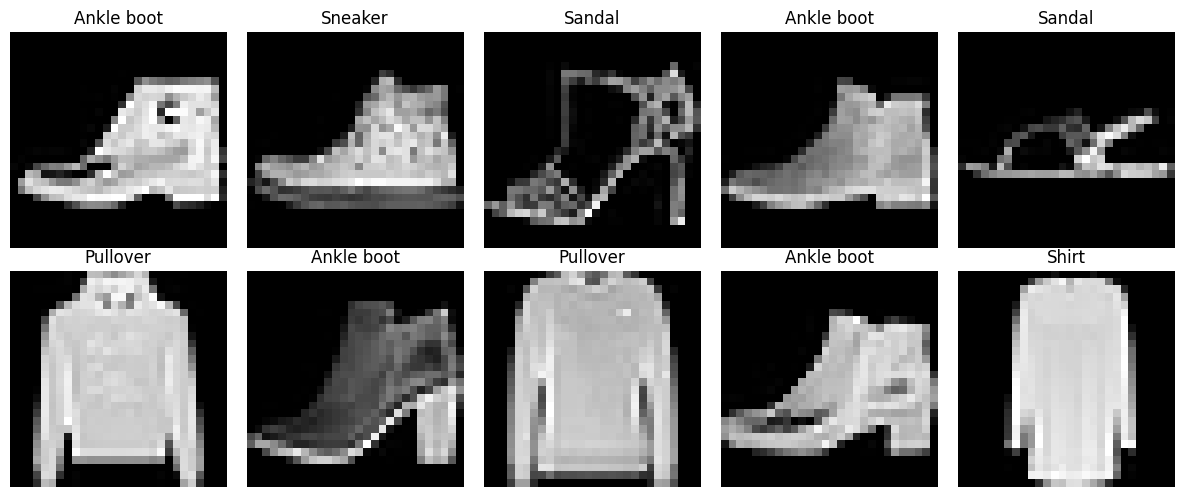

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.datasets import mnist
from sklearn.metrics import roc_curve, auc


# (1) Cargar la base de datos
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# (2) Diccionario de etiquetas a nombres de prendas
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# (3) Seleccionar 10 muestras al azar del set de test
indices = np.random.choice(len(x_test), size=10, replace=False)
images = x_test[indices]
labels = y_test[indices]

# (4) Mostrar las imágenes con sus etiquetas
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(class_names[labels[i]])
    plt.axis('off')

plt.tight_layout()
plt.show()


In [31]:
import numpy as np

class PCA:
    def __init__(self):
        """
        Inicializa atributos que se completarán tras el fit:
        - mean_: media de cada feature
        - std_: desvío estándar de cada feature
        - components_: autovectores ordenados por varianza explicada
        - explained_variance_: valores propios asociados
        - _cache: diccionario para almacenar resultados previos de transform y recon.
        """
        self.mean_ = None
        self.std_ = None
        self.components_ = None
        self.explained_variance_ = None
        self._cache = {}

    def fit(self, X):
        """
        Ajusta el PCA a los datos X normalizados (z-score).
        """
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0)

        X_norm = (X - self.mean_) / self.std_

        cov = np.cov(X_norm, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eig(cov)

        idx = np.argsort(eigenvalues)[::-1]
        self.explained_variance_ = eigenvalues[idx]
        self.components_ = eigenvectors[:, idx]

        self._cache.clear()
        return self

    def transform(self, X, k):
        """
        Proyecta X al espacio latente de dimensión k.
        """
        if self.components_ is None:
            raise ValueError("PCA no ha sido entrenado. Llamá a fit() primero.")

        X_norm = (X - self.mean_) / self.std_
        Wk = self.components_[:, :k]
        U = np.dot(X_norm, Wk)

        self._cache['last_k'] = k
        self._cache['last_U'] = U
        self._cache['last_reconstruction'] = None

        return U

    def inverse_transform(self, U):
        """
        Reconstruye datos desde espacio latente al original.
        """
        Wk = self.components_[:, :U.shape[1]]
        X_rec_norm = np.dot(U, Wk.T)
        X_rec = X_rec_norm * self.std_ + self.mean_
        return X_rec

    def fit_transform(self, X, k):
        """
        Ajusta el modelo y proyecta los datos.
        """
        self.fit(X)
        return self.transform(X, k)

    def transform_reconstruction(self, X, k, use_previous_results=False):
        """
        Proyecta y reconstruye X usando k componentes.
        Si use_previous_results es True, utiliza reconstrucciones previas para acelerar.
        """
        if not use_previous_results or 'last_reconstruction' not in self._cache or self._cache['last_reconstruction'] is None:
            U = self.transform(X, k)
            X_rec = self.inverse_transform(U)
            self._cache['last_reconstruction'] = X_rec
            self._cache['last_U'] = U
            self._cache['last_k'] = k
            return X_rec
        else:
            k_prev = self._cache.get('last_k', 0)
            X_prev = self._cache['last_reconstruction']
            U_prev = self._cache['last_U']

            if k <= k_prev:
                return X_prev

            # Transformar solo usando los componentes adicionales
            X_norm = (X - self.mean_) / self.std_
            W_add = self.components_[:, k_prev:k]
            U_add = np.dot(X_norm, W_add)

            # Concatenar para obtener U total
            U_total = np.hstack([U_prev, U_add])
            X_new = self.inverse_transform(U_total)

            # Actualizar cache
            self._cache['last_k'] = k
            self._cache['last_U'] = U_total
            self._cache['last_reconstruction'] = X_new
            return X_new

    def fit_reconstruction(self, X, k):
        """
        Ajusta y reconstruye X usando k componentes de una vez.
        """
        self.fit(X)
        return self.transform_reconstruction(X, k, use_previous_results=False)



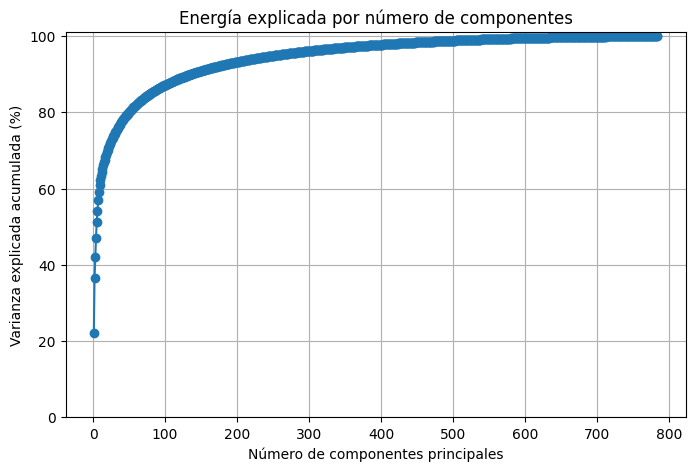

In [32]:
def plot_explained_variance(pca):
    """
    Dibuja el porcentaje acumulado de energía explicada por las componentes principales.
    """
    if pca.explained_variance_ is None:
        print("Error: PCA no ha sido entrenado. Llamá a fit() primero.")
        return

    # Normalizar autovalores para que sumen 1
    total_variance = np.sum(pca.explained_variance_)
    explained = pca.explained_variance_ / total_variance

    # Energía acumulada
    cumulative_explained = np.cumsum(explained)

    # Graficar
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(cumulative_explained)+1), cumulative_explained * 100, marker='o')
    plt.xlabel("Número de componentes principales")
    plt.ylabel("Varianza explicada acumulada (%)")
    plt.title("Energía explicada por número de componentes")
    plt.grid(True)
    plt.ylim(0, 101)
    plt.show()


# (5) Preprocesamiento para PCA
x_train_flat = x_train.reshape((x_train.shape[0], -1)).astype(np.float32)

# Crear e entrenar PCA
pca = PCA()
pca.fit(x_train_flat)

# Graficar varianza explicada
plot_explained_variance(pca)




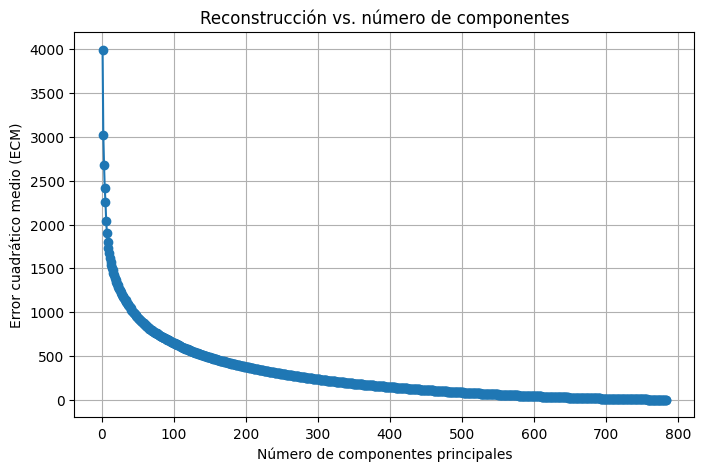

In [33]:
def plot_reconstruction_error(pca, X_test, max_k=None):
    """
    Grafica el error cuadrático medio (ECM) de reconstrucción
    en función del número de componentes principales.

    Si no se especifica max_k, se usan todas las componentes.
    """
    if pca.components_ is None:
        print("Error: PCA no ha sido entrenado. Llamá a fit() primero.")
        return

    X_test = X_test.astype(np.float32)
    total_components = pca.components_.shape[1]

    if max_k is None:
        max_k = total_components
    else:
        max_k = min(max_k, total_components)

    errors = []

    for k in range(1, max_k + 1):
        X_hat = pca.transform_reconstruction(X_test, k, use_previous_results=True)
        
        
        # Asumiendo que normalizaste con media y std
        #X_hat = X_hat * pca.std_ + pca.mean_

        mse = np.mean((X_test - X_hat) ** 2)
        errors.append(mse)

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_k + 1), errors, marker='o')
    plt.xlabel("Número de componentes principales")
    plt.ylabel("Error cuadrático medio (ECM)")
    plt.title("Reconstrucción vs. número de componentes")
    plt.grid(True)
    plt.show()


x_test_flat = x_test.reshape((x_test.shape[0], -1)).astype(np.float32)
plot_reconstruction_error(pca, x_test_flat)


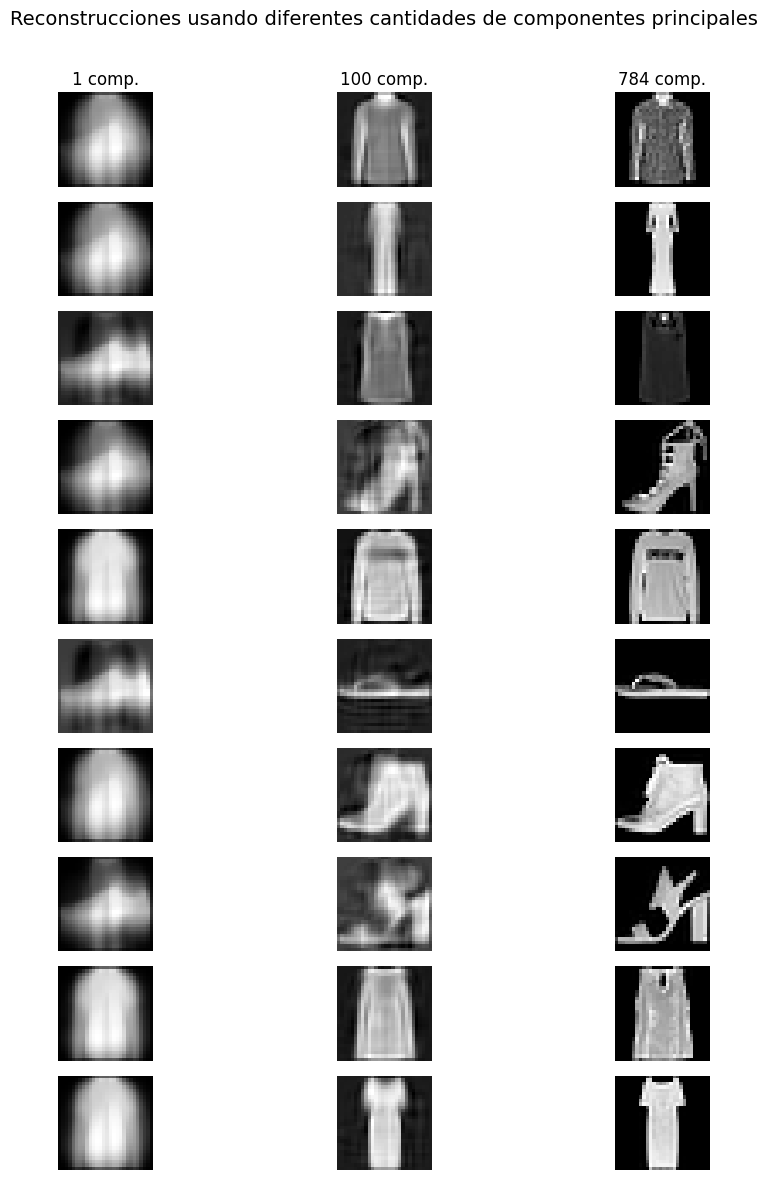

In [34]:
def mostrar_reconstrucciones(pca, X_test, random_seed=42):
    """
    Muestra 10 imágenes del conjunto de test reconstruidas con 1, 100 y 784 componentes.

    Parámetros:
    - pca: instancia de la clase PCA ya entrenada (fit hecho sobre X_train)
    - X_test: matriz de imágenes de testeo de forma (N, 784)
    - random_seed: semilla para reproducibilidad
    """
    np.random.seed(random_seed)
    idx = np.random.choice(X_test.shape[0], size=10, replace=False)
    imgs_orig = X_test[idx]

    ks = [1, 100, 784]
    fig, axes = plt.subplots(10, len(ks), figsize=(10, 12))
    fig.suptitle("Reconstrucciones usando diferentes cantidades de componentes principales", fontsize=14)

    for i, img in enumerate(imgs_orig):
        for j, k in enumerate(ks):
            img_rec = pca.transform_reconstruction(img.reshape(1, -1), k)
            axes[i, j].imshow(img_rec.reshape(28, 28), cmap='gray')
            axes[i, j].axis('off')
            if i == 0:
                axes[i, j].set_title(f"{k} comp.")

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


mostrar_reconstrucciones(pca, x_test)

In [38]:
# Cargar MNIST (dígitos)
(_, _), (X_mnist_test, _) = mnist.load_data()
X_mnist_test = X_mnist_test.reshape(-1, 784).astype(np.float32)

# Asegurarse de que x_test también esté en formato (n, 784)
x_test = x_test.reshape(-1, 784).astype(np.float32)

# Combinar
X_anomaly_test = np.vstack([x_test, X_mnist_test])
y_anomaly_test = np.array([0]*len(x_test) + [1]*len(X_mnist_test))




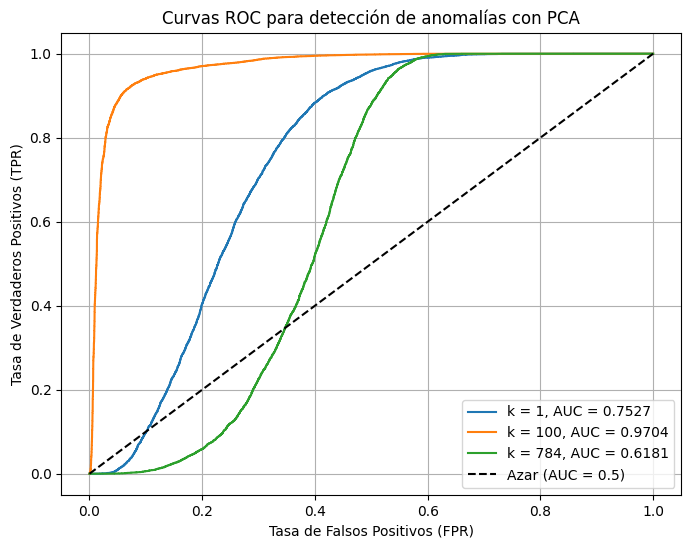

In [40]:
# Entrenar PCA con datos normales (solo Fashion-MNIST de entrenamiento)
pca = PCA()
pca.fit(x_train.reshape(-1, 784).astype(np.float32))

# Valores de k a evaluar
k_values = [1, 100, 784]
plt.figure(figsize=(8, 6))

for k in k_values:
    # Reconstrucción
    X_hat = pca.transform_reconstruction(X_anomaly_test, k, use_previous_results=False)

    # Error cuadrático medio por muestra (no promedio)
    ecm = np.mean((X_anomaly_test - X_hat) ** 2, axis=1)

    # Etiquetas: 0 = normal, 1 = anomalía
    fpr, tpr, thresholds = roc_curve(y_anomaly_test, ecm)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'k = {k}, AUC = {roc_auc:.4f}')

# Diagonal
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC = 0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC para detección de anomalías con PCA')
plt.legend()
plt.grid(True)
plt.show()
